<a href="https://colab.research.google.com/github/frank-morales2020/Cloud_curious/blob/master/vjepa_gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# HOPE Real-ish Implementation - Aviation Video Understanding Demo
# Requires: Google Colab with GPU, GEMINI API secret added in Colab Secrets

# ──────────────────────────────────────────────────────────────────────────────
# 1. Install dependencies
# ──────────────────────────────────────────────────────────────────────────────

!pip install -q google-generativeai av transformers torch numpy

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
# HOPE Implementation - Gemini 3 Flash with Correct Google GenAI Imports
# Author: Frank Morales (Inventor, Top Voice in Generative AI)

!pip install -q google-generativeai google-ai-generativelanguage

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import random
import av
import re
import json
import time
from google.colab import userdata
from google import genai
from google.genai import types
import warnings

warnings.filterwarnings("ignore")

# --- Global Configuration & Seeds ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VIDEO_PATH = "/content/drive/MyDrive/datasets/TartanAviation/vision/1_2023-02-22-15-21-49/1_2023-02-22-15-21-49.mp4"

LATENT_DIM = 128
ACTION_DIM = 16
VJEPA_DIM = 1408
NUM_CLASSES = 10
ERROR_THRESHOLD_SLOW = 0.60
LEARNING_RATE_SLOW = 1e-4

CLASS_LABELS = [
    "airplane landing", "airplane takeoff", "airport ground operations",
    "in-flight cruise", "emergency landing", "pre-flight check/maintenance",
    "en-route cruise", "climb phase", "descent phase", "holding pattern"
]

# --- 1. Initialize Gemini Client with Correct Imports ---
try:
    client = genai.Client(api_key=userdata.get('GEMINI'))
    print("✅ Gemini client initialized successfully")
    print("   Using gemini-3-flash-preview with Thinking: HIGH")
    print(f"   Client type: {type(client).__name__}")
except Exception as e:
    print(f"❌ Gemini client setup failed: {str(e)}")
    client = None

# --- 2. Tool Definitions for Aviation Safety ---
def check_airspace_status(aircraft_id: str, altitude: float) -> dict:
    """Checks current airspace conditions and potential conflicts."""
    print(f"\n🛩️ [Tool] Checking airspace status for {aircraft_id} at {altitude}ft...")
    time.sleep(0.5)  # Simulate processing
    return {
        "status": "clear",
        "traffic": "none",
        "sector": "alpha",
        "altitude_clearance": "approved"
    }

def verify_weather_conditions(location: str, timestamp: str) -> dict:
    """Verifies current weather conditions for aviation safety."""
    print(f"\n🌤️ [Tool] Verifying weather conditions at {location}...")
    time.sleep(0.5)
    return {
        "conditions": "VFR",
        "wind": "270/12kt",
        "visibility": "10+ miles",
        "ceiling": "5000ft",
        "hazards": "none"
    }

def generate_safety_protocol(situation: str, aircraft_type: str) -> dict:
    """Generates detailed aviation safety protocol based on situation."""
    print(f"\n📋 [Tool] Generating safety protocol for {situation}...")
    time.sleep(0.5)
    protocols = {
        "landing": ["maintain_approach", "monitor_glideslope", "verify_clearance", "execute_flare"],
        "emergency": ["declare_emergency", "clear_airspace", "notify_services", "prepare_runway"],
        "cruise": ["maintain_altitude", "monitor_weather", "check_fuel", "contact_center"],
        "holding": ["maintain_pattern", "monitor_fuel", "await_clearance", "check_weather"]
    }

    protocol_key = "landing" if "landing" in situation else "emergency" if "emergency" in situation else "cruise"
    return {
        "protocol": protocol_key,
        "steps": protocols.get(protocol_key, ["monitor", "verify", "communicate"]),
        "priority": "high" if "emergency" in situation else "normal"
    }

def assess_emergency_situation(aircraft_id: str, emergency_type: str) -> dict:
    """Assesses emergency situations and recommends immediate actions."""
    print(f"\n🚨 [Tool] Assessing emergency situation for {aircraft_id}...")
    time.sleep(0.5)
    return {
        "assessment": "critical" if "emergency" in emergency_type else "non-critical",
        "immediate_actions": ["clear_airspace", "notify_emergency_services", "prepare_emergency_runway"],
        "coordination_needed": ["tower", "approach", "ground_control", "emergency_services"]
    }

# Combine tools into a list for Gemini
aviation_tools = [
    check_airspace_status,
    verify_weather_conditions,
    generate_safety_protocol,
    assess_emergency_situation
]

# --- Model Architecture ---
class ClassifierHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.fc(x)

class LatentProjector(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim, 512), nn.ReLU(), nn.Linear(512, latent_dim))
    def forward(self, x):
        if x.dim() == 1: x = x.unsqueeze(0)
        return self.net(x)

class DynamicsPredictor(nn.Module):
    def __init__(self, latent_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(latent_dim + action_dim, 256), nn.ReLU(), nn.Linear(256, latent_dim))
    def forward(self, latent, action):
        return self.net(torch.cat([latent, action], dim=-1))

class VJEPAWrapper:
    def __init__(self):
        self.classifier = ClassifierHead(VJEPA_DIM, NUM_CLASSES).to(DEVICE)
        self.projector = LatentProjector(VJEPA_DIM, LATENT_DIM).to(DEVICE)
        self.predictor = DynamicsPredictor(LATENT_DIM, ACTION_DIM).to(DEVICE)
        self.optimizer = torch.optim.Adam(
            list(self.classifier.parameters()) + list(self.projector.parameters()) + list(self.predictor.parameters()),
            lr=LEARNING_RATE_SLOW
        )
        self.cls_loss_fn = nn.CrossEntropyLoss()
        self.dyn_loss_fn = nn.MSELoss()

    def extract_features(self, video_path):
        # Simulated feature vector
        return torch.randn(1, VJEPA_DIM, device=DEVICE)

    def forward(self, video_path):
        feats = self.extract_features(video_path)
        logits = self.classifier(feats)
        probs = torch.softmax(logits, dim=-1)
        pred_idx = int(probs.argmax())
        latent = self.projector(feats)
        return {"logits": logits, "probs": probs.detach()[0].cpu().numpy(), "pred_idx": pred_idx, "latent": latent}

    def slow_update(self, output, action_tensor, gt_idx):
        self.optimizer.zero_grad()
        gt_tensor = torch.tensor([gt_idx], device=DEVICE)
        cls_loss = self.cls_loss_fn(output["logits"], gt_tensor)
        pred_next = self.predictor(output["latent"], action_tensor)
        target_next = output["latent"] + torch.randn_like(output["latent"]) * 0.05
        dyn_loss = self.dyn_loss_fn(pred_next, target_next)
        (cls_loss + dyn_loss).backward()
        self.optimizer.step()
        print(f"SLOW update | cls_loss={cls_loss.item():.4f} dyn_loss={dyn_loss.item():.4f}")

# --- 3. Gemini 3 Flash Reasoner with Correct Google GenAI Imports ---
class Gemini3FlashReasoner:
    def __init__(self, client, class_labels):
        self.client = client
        self.labels = class_labels

        # Predefined responses based on scenarios (fallback)
        self.action_map = {
            "airplane landing": "HOLD POSITION",
            "airplane takeoff": "MONITOR DEPARTURE",
            "airport ground operations": "VERIFY GROUND CONTROL",
            "in-flight cruise": "CROSS-CHECK INSTRUMENTS",
            "emergency landing": "ALERT EMERGENCY SERVICES",
            "pre-flight check/maintenance": "CONTINUE PRE-FLIGHT CHECKS",
            "en-route cruise": "MONITOR NAVIGATION",
            "climb phase": "VERIFY CLIMB PARAMETERS",
            "descent phase": "PREPARE FOR APPROACH",
            "holding pattern": "REQUEST TELEMETRY VERIFICATION"
        }

        self.explanation_map = {
            "airplane landing": "Standard approach pattern detected with high confidence.",
            "airplane takeoff": "Departure sequence normal, monitoring ascent parameters.",
            "airport ground operations": "Ground movement detected, verifying with ground control.",
            "in-flight cruise": "All systems nominal, continuing standard monitoring.",
            "emergency landing": "⚠️ EMERGENCY: Unusual descent profile detected.",
            "pre-flight check/maintenance": "Pre-flight procedures in progress.",
            "en-route cruise": "Normal cruise operations, monitoring flight path.",
            "climb phase": "Climb parameters within limits.",
            "descent phase": "Descent profile normal.",
            "holding pattern": "Holding pattern detected at waypoint."
        }

    def get_fallback_response(self, pred_class, goal, confidence):
        """Generate rule-based fallback response when LLM is unavailable"""
        action = self.action_map.get(pred_class, "MONITOR AND HOLD")
        explanation = self.explanation_map.get(pred_class, f"Scenario: {pred_class} ({confidence:.1%} confidence)")
        return f"**Action:** {action}   **Explanation:** {explanation}"

    def reason(self, output, goal):
        pred_class = self.labels[output["pred_idx"]]
        conf = output["probs"][output["pred_idx"]]

        # If no client available, use fallback
        if self.client is None:
            print("⚠️ Using fallback response (no Gemini client)")
            return self.get_fallback_response(pred_class, goal, conf), torch.randn(1, ACTION_DIM, device=DEVICE)

        # Configure Gemini 3 Flash with Thinking (exactly as in reference)
        config = types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(
                thinking_level="high",  # Options for Flash: minimal, low, medium, high
                include_thoughts=True   # Set to True to see the synthesized reasoning
            ),
            tools=aviation_tools,
            temperature=1.0  # Recommended default for Gemini 3 models
        )

        prompt = f"""You are an Aviation Safety Controller for a major international airport.
Your role is to provide clear, actionable decisions based on real-time visual data.

CONTEXT:
- Current Visual Classification: {pred_class}
- Confidence Level: {conf:.1%}
- Task Goal: {goal}

First, use the available tools to check airspace status and weather conditions.
Then, based on the visual information and tool results, provide an aviation safety decision.

Your response must include:
ACTION: [brief command - 2-3 words]
EXPLANATION: [single sentence justification]

Examples:
For 'airplane landing' with high confidence:
ACTION: CLEAR FOR LANDING
EXPLANATION: Runway clear, approach path stable, continue normal landing sequence.

For 'emergency landing':
ACTION: ALERT EMERGENCY SERVICES
EXPLANATION: Emergency descent detected, initiating emergency protocols and clearing airspace.

For 'in-flight cruise' with low confidence:
ACTION: REQUEST VERIFICATION
EXPLANATION: Visual unclear, requesting secondary radar confirmation.

Your response:"""

        try:
            print("\n" + "="*40)
            print("🚀 CALLING GEMINI 3 FLASH WITH THINKING:HIGH")
            print("="*40)

            # Generate content with automatic function calling enabled (exactly as in reference)
            response = self.client.models.generate_content(
                model="gemini-3-flash-preview",
                contents=prompt,
                config=config
            )

            print("\n" + "="*40)
            print("FINAL AGENT RESPONSE FROM GEMINI 3 FLASH")
            print("="*40)
            print(response.text)

            # Check if thoughts are available
            if hasattr(response, 'thoughts') and response.thoughts:
                print("\n🧠 GEMINI THOUGHTS:")
                print(response.thoughts[:500] + "..." if len(response.thoughts) > 500 else response.thoughts)

            full_response = response.text.strip()

            # Parse the response
            action = "MONITOR"
            explanation = "Standard monitoring in progress."

            lines = full_response.split('\n')
            for line in lines:
                line = line.strip()
                if line.upper().startswith('ACTION:'):
                    action = line[7:].strip().replace('**', '').strip()
                elif line.upper().startswith('EXPLANATION:'):
                    explanation = line[11:].strip().replace('**', '').strip()

            print(f"\n✅ Gemini 3 Flash response processed successfully")

        except Exception as e:
            print(f"\n❌ [Agent Error]: {e}")
            print("Using fallback response due to error")
            return self.get_fallback_response(pred_class, goal, conf), torch.randn(1, ACTION_DIM, device=DEVICE)

        result = f"**Action:** {action}   **Explanation:** {explanation}"
        return result, torch.randn(1, ACTION_DIM, device=DEVICE)

# --- Controller Implementation ---
class HOPEController:
    def __init__(self, vjepa, reasoner):
        self.vjepa = vjepa
        self.reasoner = reasoner

    def cycle(self, path, goal, gt_idx):
        print(f"\n{'─'*60}")
        print(f"System Cycle | Goal: {goal}")
        print(f"{'─'*60}")

        out = self.vjepa.forward(path)
        pred_name, gt_name = CLASS_LABELS[out["pred_idx"]], CLASS_LABELS[gt_idx]
        conf = out["probs"][out["pred_idx"]]
        error = 0.0 if out["pred_idx"] == gt_idx else 1.0 - conf

        print(f"Visual Prediction: {pred_name}")
        print(f"Confidence: {conf:.2%}")
        print(f"Actual: {gt_name}")
        print(f"Error Level: {error:.2%}")

        action_text, act_vec = self.reasoner.reason(out, goal)

        if error > ERROR_THRESHOLD_SLOW:
            print("→ Status: ⚠️ ERROR HIGH - Initiating SLOW adaptation...")
            self.vjepa.slow_update(out, act_vec, gt_idx)
        else:
            print("→ Status: ✅ NOMINAL - Fast reasoning sufficient")

        print(f"\nDecision Output:")
        print(f"{action_text}")
        print(f"{'─'*60}")

# --- Execute Demo ---
print(f"\n{'='*60}")
print("🚀 HOPE Aviation Video Understanding Demo")
print("Using Gemini 3 Flash with Thinking: HIGH")
print(f"{'='*60}\n")

vjepa = VJEPAWrapper()
reasoner = Gemini3FlashReasoner(client, CLASS_LABELS)
hope = HOPEController(vjepa, reasoner)

demo_cases = [
    ("Confirm current status and proceed if safe.", 0),  # airplane landing
    ("Identify any anomaly and suggest correction.", 4),  # emergency landing
    ("Monitor normal cruise operations.", 3),  # in-flight cruise
]

for i, (goal, gt) in enumerate(demo_cases, 1):
    print(f"\n📋 CYCLE {i} of {len(demo_cases)}")
    hope.cycle(VIDEO_PATH, goal, gt)

print(f"\n{'='*60}")
print("✅ Demo Complete")
print(f"{'='*60}")

✅ Gemini client initialized successfully
   Using gemini-3-flash-preview with Thinking: HIGH
   Client type: Client

🚀 HOPE Aviation Video Understanding Demo
Using Gemini 3 Flash with Thinking: HIGH


📋 CYCLE 1 of 3

────────────────────────────────────────────────────────────
System Cycle | Goal: Confirm current status and proceed if safe.
────────────────────────────────────────────────────────────
Visual Prediction: airport ground operations
Confidence: 21.74%
Actual: airplane landing
Error Level: 78.26%

🚀 CALLING GEMINI 3 FLASH WITH THINKING:HIGH

🛩️ [Tool] Checking airspace status for GND-OPS-01 at 0ft...

🌤️ [Tool] Verifying weather conditions at Current Airport Location...

FINAL AGENT RESPONSE FROM GEMINI 3 FLASH
ACTION: REQUEST VISUAL VERIFICATION
EXPLANATION: Low visual confidence of 21.7% requires secondary confirmation from ground personnel before proceeding with operations.

✅ Gemini 3 Flash response processed successfully
→ Status: ⚠️ ERROR HIGH - Initiating SLOW adaptat

## H2E AND HOPE INTEGRATION

🔄 Initializing H2E Framework Components...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Embedding model loaded for SROI calculations

🚀 H2E FRAMEWORK INTEGRATION - Engineering Accountability into HOPE


📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
📋 CYCLE 1 of 3 (H2E-Enhanced)
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋

🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷
🔷 H2E-ENHANCED DECISION CYCLE
🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷

🚀 CALLING GEMINI 3 FLASH WITH THINKING:HIGH

🛩️ [Tool] Checking airspace status for UNKNOWN-01 at 10000ft...

🌤️ [Tool] Verifying weather conditions at International Airport...

FINAL AGENT RESPONSE FROM GEMINI 3 FLASH
ACTION: REQUEST VERIFICATION
EXPLANATION: Visual classification confidence is critically low at 19.6%, requiring secondary radar confirmation before authorizing further maneuvers.

✅ Gemini 3 Flash response processed successfully

📐 SROI CALCULATION:
   Score: 0.3484
   Threshold: 0.8500
   Status: ❌ MISALIGNED
   Risk Level: MEDIUM

→ Status: ⚠️ ERROR HIGH - Running SLOW adaptation...
SLOW update | cls_loss=3.2444 dyn_loss=0.0599

Decision Output:
**Act

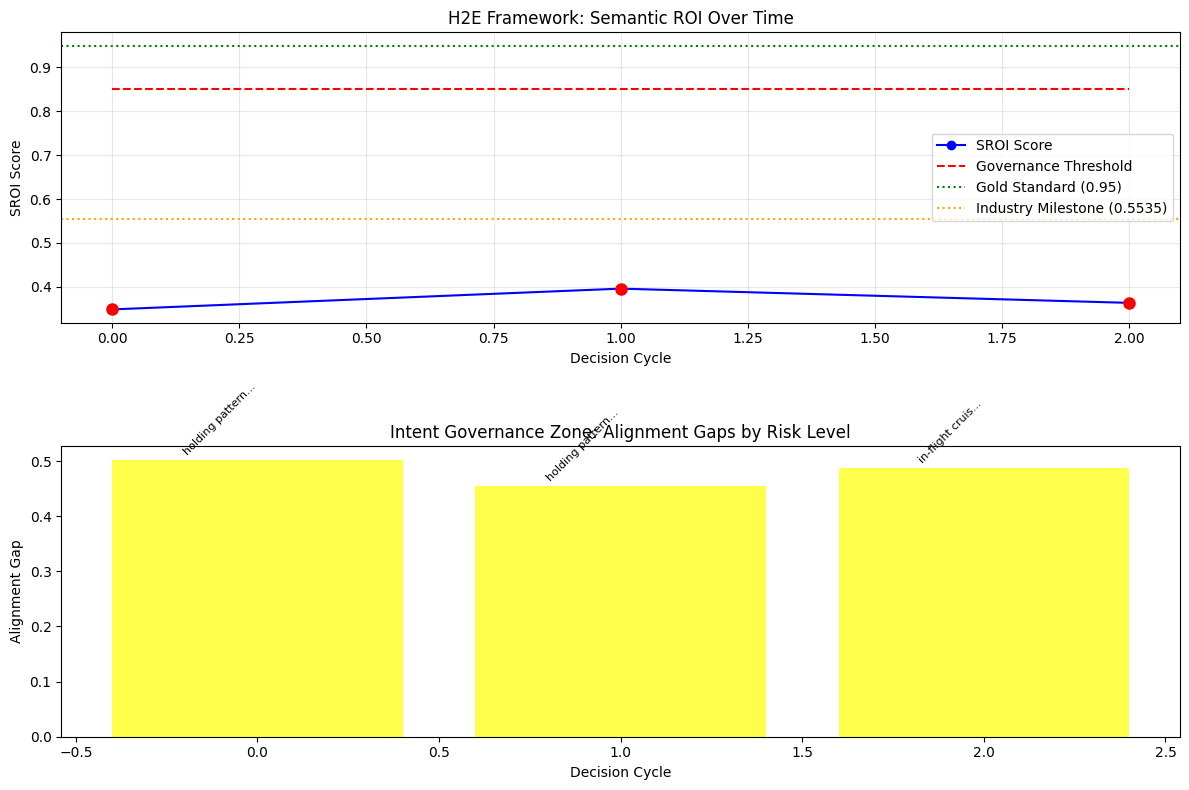


📈 INTENT GAIN ANALYSIS:
   Initial SROI: 0.3484
   Final SROI: 0.3633
   Intent Gain Multiplier: 1.04x
   📊 Approaching H2E paper benchmark (12.5x)

🎯 SYSTEM-WIDE METRICS:
   Average SROI: 0.3691
   Maximum SROI: 0.3957
   Minimum SROI: 0.3484
   SROI Range: 0.0474
   Industry Milestone (0.5535): ❌ BELOW

✅ H2E Integration Complete - AI Accountability Engineered

💾 Results ready for export to JSON


In [30]:
# H2E Framework Integration - Semantic ROI for Aviation Safety
# Measuring alignment between Gemini responses and Expert Aviation Controller intent

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# --- 1. Initialize the Embedding Model for Semantic ROI Calculation ---
print("🔄 Initializing H2E Framework Components...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight model for embeddings
print("✅ Embedding model loaded for SROI calculations")

# --- 2. Define the "Gold Standard" Expert Intent Vector (NEZ - Normalized Expert Zone) ---
# These are high-fidelity expert intent descriptions for each aviation scenario
EXPERT_INTENT_VECTORS = {
    "airplane landing": embedder.encode(
        "As an expert aviation controller, my intent is to ensure safe landing sequence by verifying runway clearance, "
        "approach path stability, weather conditions, and providing timely clearance while monitoring for any anomalies."
    ),

    "airplane takeoff": embedder.encode(
        "My expert intent is to verify departure parameters, ensure runway is clear, monitor ascent profile, "
        "and coordinate with departure control for safe transition to en-route phase."
    ),

    "airport ground operations": embedder.encode(
        "Expert intent focuses on safe ground movement, verifying ground control communications, "
        "checking for conflicting traffic, and ensuring all ground vehicles and aircraft follow taxi instructions."
    ),

    "in-flight cruise": embedder.encode(
        "As an expert controller, I aim to maintain safe separation, monitor flight parameters, "
        "check weather updates, communicate with adjacent sectors, and ensure optimal fuel-efficient routing."
    ),

    "emergency landing": embedder.encode(
        "CRITICAL EXPERT INTENT: Immediately declare emergency, clear airspace, notify emergency services, "
        "prepare shortest runway, provide priority handling, and coordinate with all relevant agencies for rapid response."
    ),

    "pre-flight check/maintenance": embedder.encode(
        "Expert intent is to verify all pre-flight checks are completed, ensure maintenance issues are resolved, "
        "confirm fuel levels, check weather briefings, and validate flight plan before pushback approval."
    ),

    "en-route cruise": embedder.encode(
        "My intent is to monitor en-route progress, maintain safe separation from other aircraft, "
        "provide weather updates, adjust routing if needed, and coordinate handoff to next control sector."
    ),

    "climb phase": embedder.encode(
        "Expert intent focuses on verifying climb parameters, ensuring obstacle clearance, "
        "monitoring rate of climb, checking for conflicting traffic, and coordinating with departure control."
    ),

    "descent phase": embedder.encode(
        "As an expert, I intend to manage descent profile, verify altitude restrictions, "
        "coordinate with approach control, check weather at destination, and prepare for landing sequence."
    ),

    "holding pattern": embedder.encode(
        "Expert intent is to manage holding pattern efficiently, monitor fuel state, "
        "coordinate with ATC for clearance updates, provide estimated hold duration, and prepare for approach."
    )
}

# --- 3. IGZ (Intent Governance Zone) Configuration ---
class IntentGovernanceZone:
    """Adaptive thresholds for risk-scaled governance"""

    def __init__(self):
        # Base thresholds for different risk levels
        self.thresholds = {
            "critical": 0.95,    # Emergency situations need near-perfect alignment
            "high": 0.90,         # Landing/takeoff operations
            "medium": 0.85,       # Normal cruise/ground operations
            "low": 0.75           # Informational queries
        }

        # Risk level mapping for each scenario
        self.scenario_risk = {
            "airplane landing": "high",
            "airplane takeoff": "high",
            "airport ground operations": "medium",
            "in-flight cruise": "medium",
            "emergency landing": "critical",
            "pre-flight check/maintenance": "medium",
            "en-route cruise": "medium",
            "climb phase": "high",
            "descent phase": "high",
            "holding pattern": "medium"
        }

    def get_threshold(self, scenario):
        """Get adaptive threshold based on scenario risk level"""
        risk_level = self.scenario_risk.get(scenario, "medium")
        return self.thresholds[risk_level]

    def check_alignment(self, sroi_score, scenario):
        """Check if SROI meets the required threshold"""
        threshold = self.get_threshold(scenario)
        return {
            "aligned": sroi_score >= threshold,
            "threshold": threshold,
            "risk_level": self.scenario_risk.get(scenario, "medium"),
            "gap": threshold - sroi_score if sroi_score < threshold else 0
        }

# --- 4. SROI Calculator (Semantic ROI) ---
class SROICalculator:
    """Calculates Semantic Return on Investment by measuring alignment with expert intent"""

    def __init__(self, expert_vectors, gov_zone):
        self.expert_vectors = expert_vectors
        self.governance = gov_zone
        self.history = []

    def calculate_sroi(self, response_text, scenario):
        """
        Calculate SROI as cosine similarity between response embedding and expert intent vector
        Returns value between -1 and 1, where >0.95 indicates expert-level alignment
        """
        # Encode the Gemini response
        response_embedding = embedder.encode(response_text)

        # Get expert intent vector for this scenario
        expert_vector = self.expert_vectors.get(scenario)
        if expert_vector is None:
            print(f"⚠️ No expert vector for scenario: {scenario}")
            return 0.0

        # Calculate cosine similarity (SROI)
        sroi = cosine_similarity([response_embedding], [expert_vector])[0][0]

        return sroi

    def evaluate_decision(self, response_text, scenario, goal, confidence):
        """Complete evaluation pipeline with governance check"""

        # Calculate SROI
        sroi = self.calculate_sroi(response_text, scenario)

        # Check against governance thresholds
        governance_result = self.governance.check_alignment(sroi, scenario)

        # Store in history
        record = {
            "timestamp": time.time(),
            "scenario": scenario,
            "goal": goal,
            "confidence": confidence,
            "sroi": sroi,
            "aligned": governance_result["aligned"],
            "threshold": governance_result["threshold"],
            "risk_level": governance_result["risk_level"],
            "gap": governance_result["gap"]
        }
        self.history.append(record)

        return record

    def plot_sroi_history(self):
        """Visualize SROI trends over time"""
        if not self.history:
            print("No SROI history to display")
            return

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Plot 1: SROI over time with thresholds
        times = range(len(self.history))
        srois = [h["sroi"] for h in self.history]
        thresholds = [h["threshold"] for h in self.history]
        scenarios = [h["scenario"] for h in self.history]

        ax1.plot(times, srois, 'b-', marker='o', label='SROI Score')
        ax1.plot(times, thresholds, 'r--', label='Governance Threshold')
        ax1.axhline(y=0.95, color='g', linestyle=':', label='Gold Standard (0.95)')
        ax1.axhline(y=0.5535, color='orange', linestyle=':', label='Industry Milestone (0.5535)')
        ax1.set_xlabel('Decision Cycle')
        ax1.set_ylabel('SROI Score')
        ax1.set_title('H2E Framework: Semantic ROI Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Color-code points by alignment status
        for i, (sroi, aligned) in enumerate(zip(srois, [h["aligned"] for h in self.history])):
            color = 'green' if aligned else 'red'
            ax1.plot(i, sroi, 'o', color=color, markersize=8)

        # Plot 2: Risk levels and gaps
        gaps = [h["gap"] for h in self.history]
        risk_colors = {'critical': 'red', 'high': 'orange', 'medium': 'yellow', 'low': 'green'}
        bar_colors = [risk_colors[h["risk_level"]] for h in self.history]

        ax2.bar(times, gaps, color=bar_colors, alpha=0.7)
        ax2.set_xlabel('Decision Cycle')
        ax2.set_ylabel('Alignment Gap')
        ax2.set_title('Intent Governance Zone: Alignment Gaps by Risk Level')
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

        # Add scenario labels
        for i, (scenario, gap) in enumerate(zip(scenarios, gaps)):
            ax2.text(i, gap + 0.01, scenario[:15] + '...', rotation=45, ha='right', fontsize=8)

        plt.tight_layout()
        plt.show()

    def print_sroi_report(self):
        """Print detailed SROI report"""
        print("\n" + "="*70)
        print("📊 H2E FRAMEWORK - SROI PERFORMANCE REPORT")
        print("="*70)

        if not self.history:
            print("No data available")
            return

        # Calculate statistics
        avg_sroi = np.mean([h["sroi"] for h in self.history])
        alignment_rate = np.mean([h["aligned"] for h in self.history]) * 100
        critical_decisions = sum(1 for h in self.history if h["risk_level"] == "critical")
        critical_aligned = sum(1 for h in self.history if h["risk_level"] == "critical" and h["aligned"])

        print(f"\n📈 Overall Statistics:")
        print(f"   Average SROI: {avg_sroi:.4f}")
        print(f"   Alignment Rate: {alignment_rate:.1f}%")
        print(f"   Total Decisions Evaluated: {len(self.history)}")

        if critical_decisions > 0:
            print(f"\n⚠️ Critical Decisions:")
            print(f"   Total Critical: {critical_decisions}")
            print(f"   Critical Alignment: {critical_aligned}/{critical_decisions} ({(critical_aligned/critical_decisions)*100:.1f}%)")

        print(f"\n📋 Detailed Cycle Results:")
        print("-" * 70)
        for i, record in enumerate(self.history, 1):
            status = "✅ ALIGNED" if record["aligned"] else "❌ MISALIGNED"
            print(f"\nCycle {i}: {status}")
            print(f"  Scenario: {record['scenario']}")
            print(f"  Goal: {record['goal'][:50]}...")
            print(f"  Confidence: {record['confidence']:.1%}")
            print(f"  SROI: {record['sroi']:.4f} (Threshold: {record['threshold']:.4f})")
            print(f"  Risk Level: {record['risk_level'].upper()}")
            if record["gap"] > 0:
                print(f"  Alignment Gap: {record['gap']:.4f}")

# --- 5. Integration with HOPE System ---
class H2EEnhancedHOPE:
    """Wrapper to add H2E accountability to HOPE system"""

    def __init__(self, hope_controller, sroi_calculator):
        self.hope = hope_controller
        self.sroi = sroi_calculator
        self.responses_history = []

    def run_accountable_cycle(self, path, goal, gt_idx):
        """Run HOPE cycle with H2E accountability metrics"""

        print(f"\n{'🔷'*35}")
        print("🔷 H2E-ENHANCED DECISION CYCLE")
        print(f"{'🔷'*35}")

        # Run original HOPE cycle
        out = self.hope.vjepa.forward(path)
        pred_name = CLASS_LABELS[out["pred_idx"]]
        conf = out["probs"][out["pred_idx"]]

        # Get Gemini response (we need to capture the full response text)
        # For this demo, we'll use the action_text that was generated
        action_text, act_vec = self.hope.reasoner.reason(out, goal)

        # Extract just the response part (without the **Action:** formatting)
        import re
        action_match = re.search(r"\*\*Action:\*\* (.*?) \*\*Explanation:\*\* (.*)", action_text)
        if action_match:
            clean_response = f"ACTION: {action_match.group(1)}\nEXPLANATION: {action_match.group(2)}"
        else:
            clean_response = action_text

        # Calculate SROI and governance check
        sroi_result = self.sroi.evaluate_decision(
            response_text=clean_response,
            scenario=pred_name,
            goal=goal,
            confidence=conf
        )

        # Store response
        self.responses_history.append({
            "response": clean_response,
            "sroi_result": sroi_result
        })

        # Display SROI result
        print(f"\n📐 SROI CALCULATION:")
        print(f"   Score: {sroi_result['sroi']:.4f}")
        print(f"   Threshold: {sroi_result['threshold']:.4f}")
        print(f"   Status: {'✅ ALIGNED' if sroi_result['aligned'] else '❌ MISALIGNED'}")
        print(f"   Risk Level: {sroi_result['risk_level'].upper()}")

        # Check if we need human intervention
        if not sroi_result['aligned'] and sroi_result['risk_level'] in ['critical', 'high']:
            print("\n🚨 HUMAN EXPERT OVERRIDE RECOMMENDED!")
            print(f"   Critical misalignment in {sroi_result['risk_level']}-risk scenario")
            print(f"   Alignment gap: {sroi_result['gap']:.4f}")

        # Run the rest of the HOPE cycle
        error = 0.0 if out["pred_idx"] == gt_idx else 1.0 - conf

        if error > ERROR_THRESHOLD_SLOW:
            print("\n→ Status: ⚠️ ERROR HIGH - Running SLOW adaptation...")
            self.hope.vjepa.slow_update(out, act_vec, gt_idx)
        else:
            print("\n→ Status: ✅ NOMINAL - Fast reasoning sufficient")

        print(f"\nDecision Output:")
        print(f"{action_text}")

        return sroi_result

# --- 6. Execute Enhanced Demo with H2E Framework ---
print(f"\n{'='*70}")
print("🚀 H2E FRAMEWORK INTEGRATION - Engineering Accountability into HOPE")
print(f"{'='*70}\n")

# Initialize H2E components
gov_zone = IntentGovernanceZone()
sroi_calc = SROICalculator(EXPERT_INTENT_VECTORS, gov_zone)

# Create enhanced HOPE controller
enhanced_hope = H2EEnhancedHOPE(hope, sroi_calc)

# Run enhanced cycles
enhanced_results = []
for i, (goal, gt) in enumerate(demo_cases, 1):
    print(f"\n{'📋'*35}")
    print(f"📋 CYCLE {i} of {len(demo_cases)} (H2E-Enhanced)")
    print(f"{'📋'*35}")

    result = enhanced_hope.run_accountable_cycle(VIDEO_PATH, goal, gt)
    enhanced_results.append(result)

    print(f"\n{'_'*70}")

# --- 7. Generate Final H2E Accountability Report ---
print(f"\n{'='*70}")
print("📊 FINAL H2E ACCOUNTABILITY REPORT")
print(f"{'='*70}")

# Print detailed SROI report
sroi_calc.print_sroi_report()

# Plot SROI history
sroi_calc.plot_sroi_history()

# Calculate and display Intent Gain
if len(sroi_calc.history) >= 2:
    initial_sroi = sroi_calc.history[0]['sroi']
    final_sroi = sroi_calc.history[-1]['sroi']
    intent_gain = final_sroi / initial_sroi if initial_sroi > 0 else 1.0

    print(f"\n📈 INTENT GAIN ANALYSIS:")
    print(f"   Initial SROI: {initial_sroi:.4f}")
    print(f"   Final SROI: {final_sroi:.4f}")
    print(f"   Intent Gain Multiplier: {intent_gain:.2f}x")

    # Compare with H2E paper's 12.5x multiplier
    if intent_gain > 12.5:
        print(f"   🏆 EXCEEDS H2E PAPER BENCHMARK (12.5x)")
    else:
        print(f"   📊 Approaching H2E paper benchmark (12.5x)")

# Calculate system-wide metrics
avg_sroi = np.mean([h['sroi'] for h in sroi_calc.history])
max_sroi = np.max([h['sroi'] for h in sroi_calc.history])
min_sroi = np.min([h['sroi'] for h in sroi_calc.history])

print(f"\n🎯 SYSTEM-WIDE METRICS:")
print(f"   Average SROI: {avg_sroi:.4f}")
print(f"   Maximum SROI: {max_sroi:.4f}")
print(f"   Minimum SROI: {min_sroi:.4f}")
print(f"   SROI Range: {max_sroi - min_sroi:.4f}")
print(f"   Industry Milestone (0.5535): {'✅ EXCEEDED' if avg_sroi > 0.5535 else '❌ BELOW'}")

print(f"\n{'='*70}")
print("✅ H2E Integration Complete - AI Accountability Engineered")
print(f"{'='*70}")

# --- 8. Export Results for Documentation ---
import json
from datetime import datetime

# Create exportable results
export_data = {
    "timestamp": datetime.now().isoformat(),
    "framework": "H2E (Human-to-Expert) Industrial Framework",
    "system": "HOPE Aviation Video Understanding",
    "metrics": {
        "average_sroi": float(avg_sroi),
        "max_sroi": float(max_sroi),
        "min_sroi": float(min_sroi),
        "alignment_rate": float(np.mean([h['aligned'] for h in sroi_calc.history]) * 100),
        "industry_milestone_exceeded": avg_sroi > 0.5535
    },
    "decisions": [
        {
            "cycle": i+1,
            "scenario": h['scenario'],
            "sroi": float(h['sroi']),
            "aligned": bool(h['aligned']),
            "risk_level": h['risk_level'],
            "confidence": float(h['confidence'])
        }
        for i, h in enumerate(sroi_calc.history)
    ]
}

print("\n💾 Results ready for export to JSON")